# Overview Analysis

#### Reading the data

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname="telecom",  # Database name
    user="postgres",  # Username
    password="12345",  # Your PostgreSQL password
    host="localhost"  # Database server
)

# Query to fetch all xDR records
query = "SELECT * FROM xdr_data;"  # Adjust the table name as needed

# Load the data into a pandas DataFrame
df = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# Display first few rows of the dataset to understand its structure
print(df.head())

C:\Users\Hp\AppData\Local\Temp\ipykernel_14456\2685453831.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

In [2]:
print(df.columns)

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


### Cleaning the data

In [5]:
import numpy as np
### 1. Remove Duplicates ###
df.drop_duplicates(inplace=True)

### 2. Handle Missing Values ###
# Get only numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Fill missing values for numeric columns with the mean
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# For non-numeric (categorical) columns, replace missing values with the most frequent value (mode)
categorical_columns = df.select_dtypes(exclude=[np.number]).columns
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

### 3. Handle Outliers ###
from scipy import stats

# Z-score method: Flag values beyond 3 standard deviations from the mean
z_scores = np.abs(stats.zscore(df[numeric_columns]))
df = df[(z_scores < 3).all(axis=1)]  # Keeping only data points with z-scores < 3

# Alternatively, you can use the IQR method to remove outliers if needed
# (Q1 = 25th percentile, Q3 = 75th percentile)
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

### 4. Data Type Conversions ###
# Convert columns like 'Date' to datetime format if necessary
# df['Date'] = pd.to_datetime(df['Date'])

### 5. Check for Invalid Data ###
# Example: Check for negative values in numerical columns like 'Total DL (Bytes)', 'Total UL (Bytes)', etc.
invalid_data = df[(df['Total DL (Bytes)'] < 0) | (df['Total UL (Bytes)'] < 0)]
print(f"Found {len(invalid_data)} rows with invalid data (negative values)")

# Optionally, remove these rows if they are invalid
df = df[(df['Total DL (Bytes)'] >= 0) & (df['Total UL (Bytes)'] >= 0)]

# The cleaned dataframe can now be used for further analysis.
print("Data cleaning completed. Cleaned data is ready for analysis.")

Found 0 rows with invalid data (negative values)
Data cleaning completed. Cleaned data is ready for analysis.


### Data visualization

Top 10 Handsets Used by Customers:
                  handset_model  usage_count
0       Apple iPhone 6S (A1688)         5718
1        Apple iPhone 6 (A1586)         5195
2        Apple iPhone 7 (A1778)         3451
3       Apple iPhone Se (A1723)         3304
4                     undefined         3234
5        Apple iPhone 8 (A1905)         2892
6       Apple iPhone Xr (A2105)         2513
7  Samsung Galaxy S8 (Sm-G950F)         2204
8        Apple iPhone X (A1901)         2111
9    Samsung Galaxy A5 Sm-A520F         2077
Top 3 Handset Manufacturers:
  manufacturer  usage_count
0        Apple        33676
1      Samsung        19766
2    undefined         3234
Top 5 Handsets per Top 3 Manufacturers:
   manufacturer                 handset_model  usage_count
0         Apple       Apple iPhone 6S (A1688)         5718
1         Apple        Apple iPhone 6 (A1586)         5195
2         Apple        Apple iPhone 7 (A1778)         3451
3         Apple       Apple iPhone Se (A1723)        

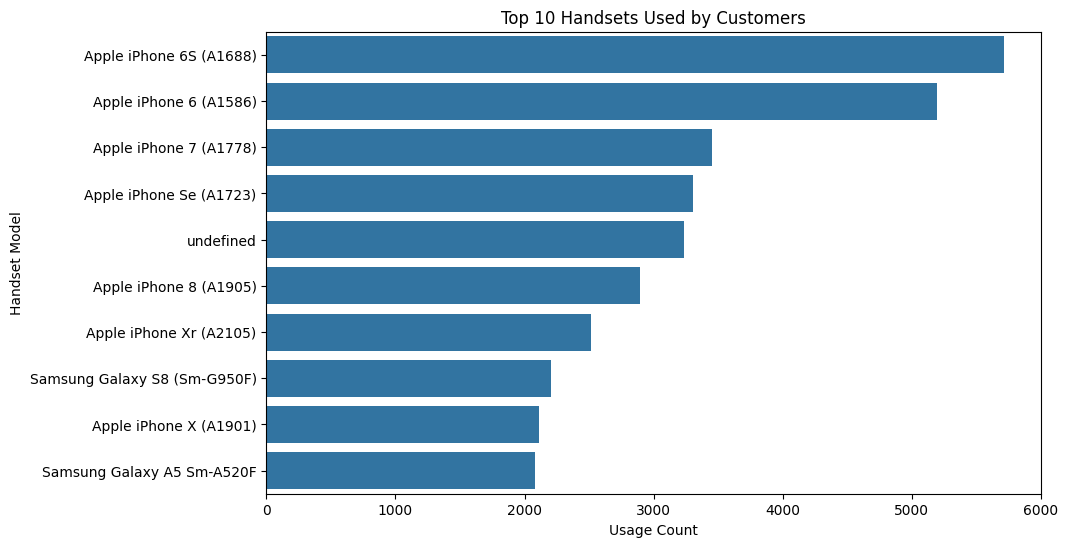

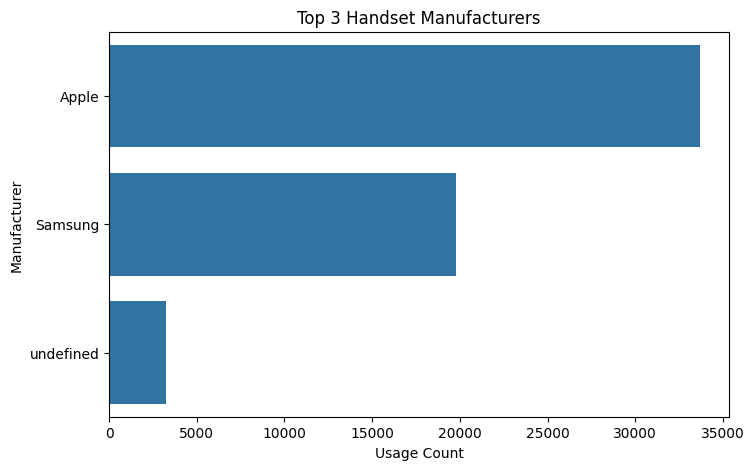

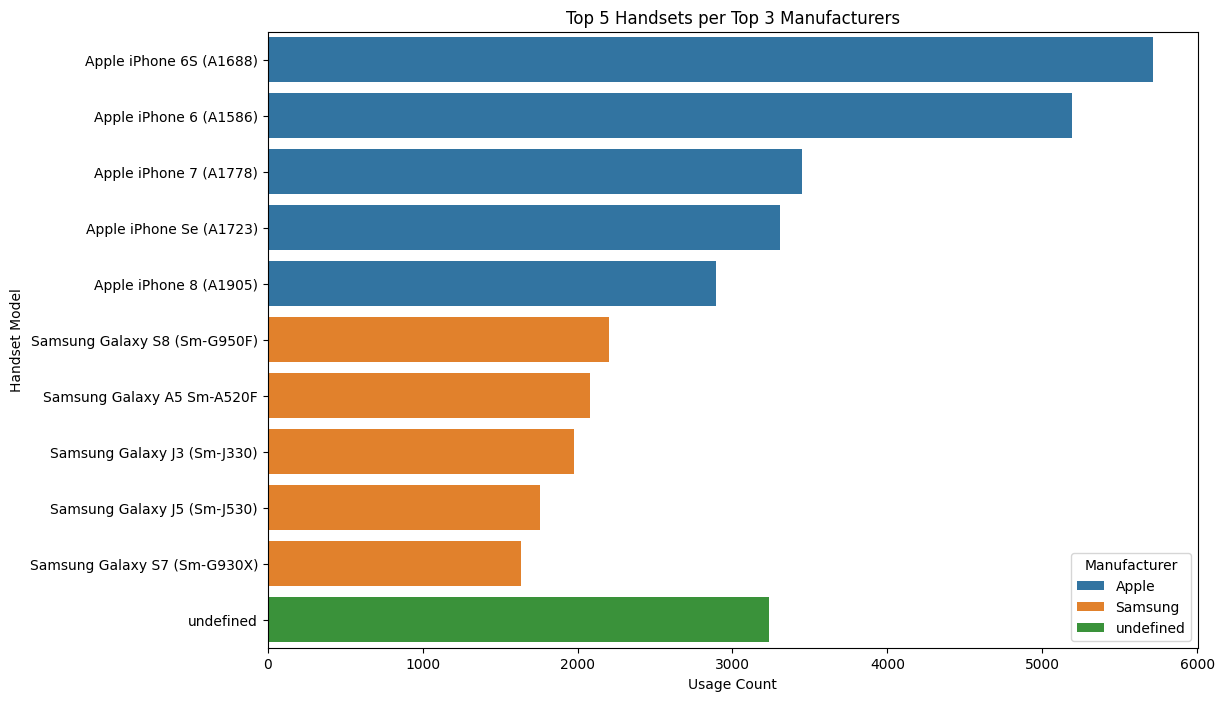

In [6]:

### 1. Top 10 Handsets Used by Customers
top_handsets = df.groupby('Handset Type')['IMEI'].count().nlargest(10).reset_index()
top_handsets.columns = ['handset_model', 'usage_count']
print("Top 10 Handsets Used by Customers:")
print(top_handsets)

### 2. Top 3 Handset Manufacturers
top_manufacturers = df.groupby('Handset Manufacturer')['IMEI'].count().nlargest(3).reset_index()
top_manufacturers.columns = ['manufacturer', 'usage_count']
print("Top 3 Handset Manufacturers:")
print(top_manufacturers)

### 3. Top 5 Handsets per Top 3 Manufacturers
top_3_manufacturers = top_manufacturers['manufacturer'].tolist()

# Filter the data for the top 3 manufacturers
filtered_df = df[df['Handset Manufacturer'].isin(top_3_manufacturers)]

# Find top 5 handsets for each manufacturer
top_5_handsets_per_manufacturer = (
    filtered_df.groupby(['Handset Manufacturer', 'Handset Type'])['IMEI'].count()
    .groupby(level=0, group_keys=False)
    .nlargest(5).reset_index()
)
top_5_handsets_per_manufacturer.columns = ['manufacturer', 'handset_model', 'usage_count']
print("Top 5 Handsets per Top 3 Manufacturers:")
print(top_5_handsets_per_manufacturer)

### 4. User Behavior on Applications

# Aggregate user behavior per application
app_behavior = df.groupby(['IMEI']).agg(
    total_sessions=('IMEI', 'count'),
    total_session_duration=('Dur. (ms)', 'sum'),
    total_download=('Total DL (Bytes)', 'sum'),
    total_upload=('Total UL (Bytes)', 'sum'),
).reset_index()

print("User Behavior on Applications:")
print(app_behavior.head())

### Visualization of Results

# a. Top 10 Handsets Used by Customers
plt.figure(figsize=(10, 6))
sns.barplot(x='usage_count', y='handset_model', data=top_handsets)
plt.title('Top 10 Handsets Used by Customers')
plt.xlabel('Usage Count')
plt.ylabel('Handset Model')
plt.show()

# b. Top 3 Handset Manufacturers
plt.figure(figsize=(8, 5))
sns.barplot(x='usage_count', y='manufacturer', data=top_manufacturers)
plt.title('Top 3 Handset Manufacturers')
plt.xlabel('Usage Count')
plt.ylabel('Manufacturer')
plt.show()

# c. Top 5 Handsets per Top 3 Manufacturers
plt.figure(figsize=(12, 8))
sns.barplot(x='usage_count', y='handset_model', hue='manufacturer', data=top_5_handsets_per_manufacturer)
plt.title('Top 5 Handsets per Top 3 Manufacturers')
plt.xlabel('Usage Count')
plt.ylabel('Handset Model')
plt.legend(title='Manufacturer')
plt.show()